In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# ❤️ Heart Disease 🤒

The data today is from the [Framingham Heart Study](https://www.framinghamheartstudy.org/).  Below excerpt from [their wikipedia page](https://en.wikipedia.org/wiki/Framingham_Heart_Study):

> The Framingham Heart Study is a long-term, ongoing cardiovascular cohort study of residents of the city of Framingham, Massachusetts. The study began in 1948 with 5,209 adult subjects from Framingham, and is now on its fourth generation of participants. Prior to the study almost nothing was known about the epidemiology of hypertensive or arteriosclerotic cardiovascular disease. Much of the now-common knowledge concerning heart disease, such as the effects of diet, exercise, and common medications such as aspirin, is based on this longitudinal study.

### Warm-up 🥵

Warm-up warm-ups
* Describe what boosting is.
* How do random forests avoid overfitting?

Actual warm-up
* How do we use residuals in gradient boosted trees?
* How do we avoid overfitting in gradient boosted trees?

## Data Import and EDA

In [2]:
# !pip install xgboost

<IPython.core.display.Javascript object>

In [3]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    make_scorer,
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# p much in practice:
# *if you want to use GradientBoostingClassifier
#     * use XGBClassifier instead
# *if you want to use GradientBoostingRegressor
#     * use XGBRegressor instead
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
data_url = "https://docs.google.com/spreadsheets/d/1Tx7KJ7iW8IkiU-aERYFXsKvDsbFJbr80POW_2DyuYGQ/export?format=csv"
heart = pd.read_csv(data_url)
heart = heart.dropna()

<IPython.core.display.Javascript object>

Do basic EDA to get familiar with this heart data.

In [6]:
heart.shape

(3658, 16)

<IPython.core.display.Javascript object>

In [7]:
heart.head(3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0


<IPython.core.display.Javascript object>

In [8]:
bin_cols = [
    "male",
    "currentSmoker",
    "BPMeds",
    "prevalentStroke",
    "prevalentHyp",
    "diabetes",
]

num_cols = [
    "age",
    "education",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]

<IPython.core.display.Javascript object>

Do we have balanced classes?  If our model gets 85% accuracy, should we consider that good?
* Calculate percentages of each class using `value_counts` and the `normalize` argument
* Show a bar plot of the counts of each class

In [9]:
heart["TenYearCHD"].value_counts(normalize=True)

0    0.847731
1    0.152269
Name: TenYearCHD, dtype: float64

<IPython.core.display.Javascript object>

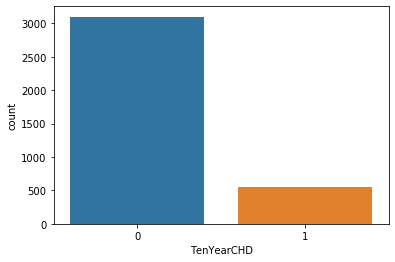

<IPython.core.display.Javascript object>

In [10]:
sns.countplot(heart["TenYearCHD"])
plt.show()

Let's visualize our data with respect to our target variable, `'TenYearCHD'`.  We actually have a lot of categorical variables here that are already encoded as numbers for us. We might consider re-encoding education, but it's already encoded as ordinal, let's keep it as is and come back if we think it will help.

However, it might make more sense to visualize these as categorical rather than continuous.

In [11]:
# bin_cols = [
#     "male",
#     "BPMeds",
#     "prevalentStroke",
#     "prevalentHyp",
#     "diabetes",
# ]


# num_cols = [
#     "age",
#     "cigsPerDay",
#     "totChol",
#     "diaBP",
#     "BMI",
#     "heartRate",
#     "glucose",
# ]

<IPython.core.display.Javascript object>

* What's an appropriate chart type to plot our categorical variables with our categorical target variable?
* Write a `for` loop to iterate over the categorical column names (in `bin_cols`)
* Show a plot of `'TenYearCHD'` with each of the categorical variables.

,TenYearCHD
male,
0,0.122850
1,0.189156


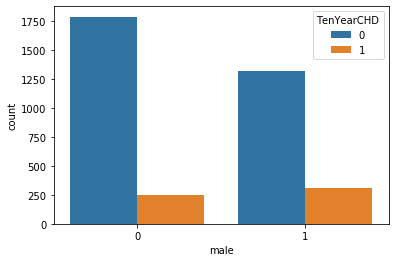

,TenYearCHD
currentSmoker,
0,0.145532
1,0.159307


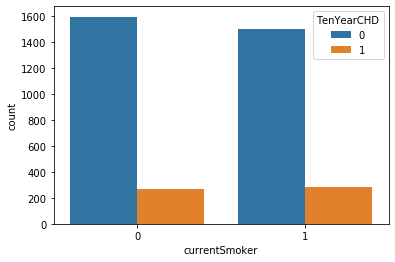

,TenYearCHD
BPMeds,
0.0,0.146603
1.0,0.333333


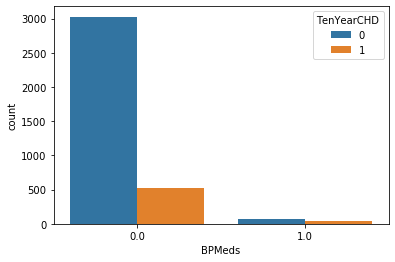

,TenYearCHD
prevalentStroke,
0,0.150949
1,0.380952


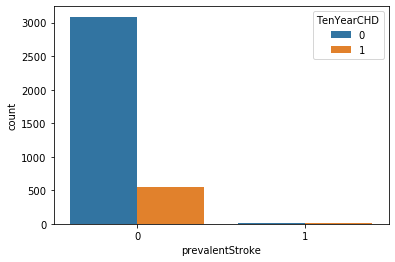

,TenYearCHD
prevalentHyp,
0,0.108419
1,0.249123


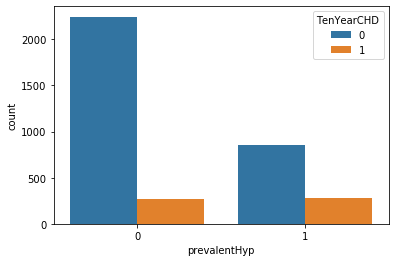

,TenYearCHD
diabetes,
0,0.146670
1,0.353535


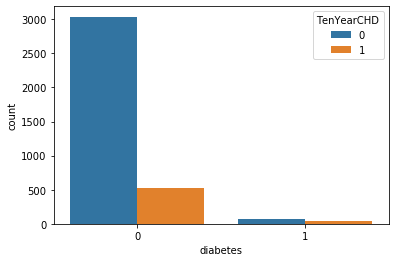

<IPython.core.display.Javascript object>

In [12]:
for col in bin_cols:
    perc_chd = heart[["TenYearCHD", col]].groupby(col).mean()
    display(perc_chd)

    sns.countplot(hue="TenYearCHD", x=col, data=heart)
    plt.show()

* What's an appropriate chart type to plot our continuous variables with our categorical target variable?

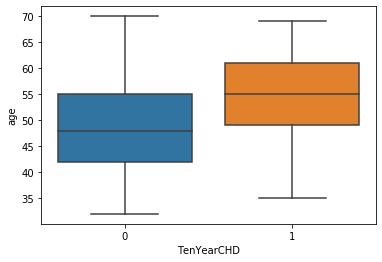

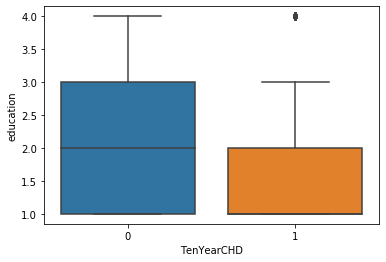

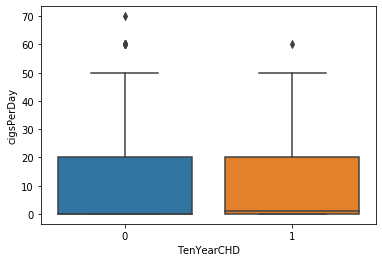

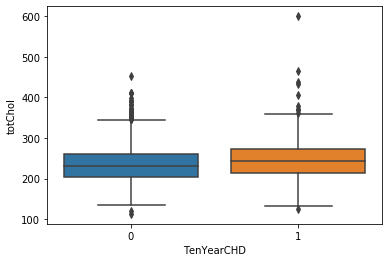

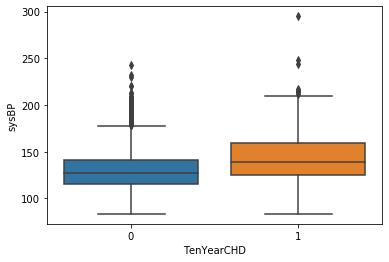

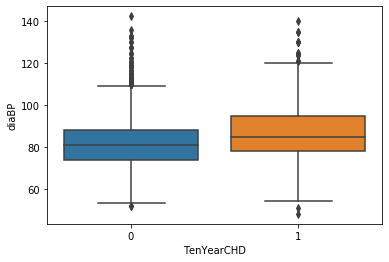

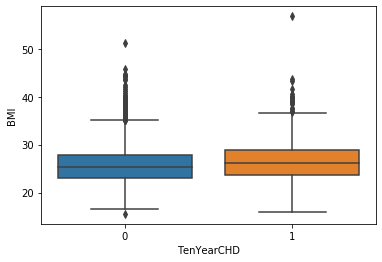

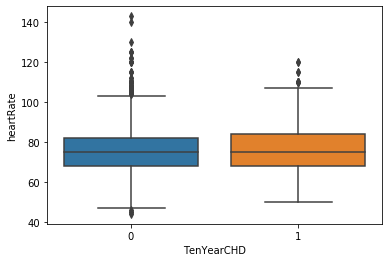

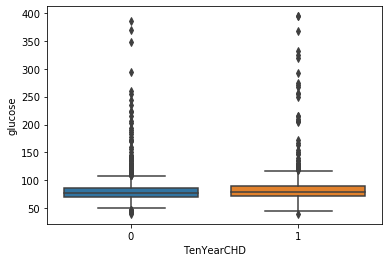

<IPython.core.display.Javascript object>

In [13]:
for col in num_cols:
    sns.boxplot("TenYearCHD", col, data=heart)
    plt.show()

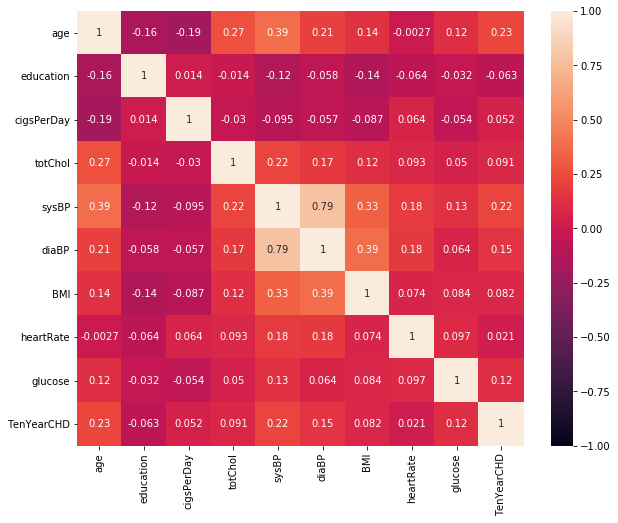

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(heart[num_cols + ["TenYearCHD"]].corr(), vmin=-1, vmax=1, annot=True)
plt.show()


## Model Prep

* Perform a train test split

In [15]:
# sysBP and currentSmoker dropped based on VIF
# sysBP redundant with diaBP
# currentSmoker redundant with cigsPerDay
X = heart.drop(columns=["TenYearCHD", "sysBP", "currentSmoker"])
y = heart["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [16]:
print_vif(X_train)

VIF results
-------------------------------
const              187.836814
male                 1.171169
age                  1.249231
education            1.053391
cigsPerDay           1.202625
BPMeds               1.100326
prevalentStroke      1.022715
prevalentHyp         1.793901
diabetes             1.588022
totChol              1.125044
diaBP                1.795818
BMI                  1.241909
heartRate            1.093189
glucose              1.594496
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

* Define a `ColumnTransformer` to scale the numeric columns
   * Leave the remaining columns untouched

In [17]:
bin_cols = [
    "male",
    "BPMeds",
    "prevalentStroke",
    "prevalentHyp",
    "diabetes",
]


num_cols = [
    "age",
    "cigsPerDay",
    "totChol",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]

<IPython.core.display.Javascript object>

In [18]:
# fmt: off
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    
], remainder='passthrough')
# fmt: on

<IPython.core.display.Javascript object>

* Define a `Pipeline` with:
    * the `ColumnTransformer` preprocessing as the first step
    * an `XGBClassifier` as the second step

In [19]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', XGBClassifier())
])
# fmt: on

<IPython.core.display.Javascript object>

In [20]:
import xgboost

xgboost.__version__

'1.2.0'

<IPython.core.display.Javascript object>

* Fit the pipeline to the training data with the default params


* What is the overall accuracy?
* Are we overfitting?
* Is this a good accuracy?

In [21]:
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9931647300068353
Test score: 0.825136612021858


<IPython.core.display.Javascript object>

* How are we making mistakes?
  * Show a `confusion_matrix` and a `classification report`
* In the context of the problem, what kind of mistake is the worst to make?
   * Mistake 1: Tell someone they're at risk when they're not
   * Mistake 2: Tell someone they're not at risk when they are
* Based on that, what number from a `classification_report` are we most interested in?
   * Do we want to maximize or minimize this value?

In [22]:
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[594  27]
 [101  10]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       621
           1       0.27      0.09      0.14       111

    accuracy                           0.83       732
   macro avg       0.56      0.52      0.52       732
weighted avg       0.77      0.83      0.79       732



<IPython.core.display.Javascript object>

We can try a grid search to see if we get better performance with better parameters.  This is one of the `xgboost` author's thoughts on the hyperparameter tuning.

<img src='https://i.stack.imgur.com/9GgQK.jpg' width='70%'>

Translation of main parameters of interest:
* Name in table - `xgb_parameter_name`

---

* \# of Trees - `n_estimators`
* Learning Rate - `learning_rate`
* Row Sampling - `subsample`
* Column Sampling - `colsample_bytree`
* Max Tree Depth - `max_depth`

---

* Set up a grid search using this pictured slide as guidance
* What were the best params according to this search?

In [23]:
# Adjusted max_features/max_depth to have smaller grid
params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__max_depth": [5, 7, 10],
}

n_trees = 100
learning_rate = 2 / n_trees

<IPython.core.display.Javascript object>

In [24]:
pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

<IPython.core.display.Javascript object>

In [25]:
# f1 scorer
# pipeline_cv = GridSearchCV(
#     pipeline, params, verbose=1, cv=2, scoring=make_scorer(f1_score),
# )

# fbeta scorer
pipeline_cv = GridSearchCV(
    pipeline, params, cv=2, scoring=make_scorer(fbeta_score, beta=5), verbose=1, n_jobs=-1
)

pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_


Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.6s finished


{'xgb__colsample_bytree': 1.0, 'xgb__max_depth': 10, 'xgb__subsample': 1.0}

<IPython.core.display.Javascript object>

* How does this affect our performance?
* Would we want to deploy this model to predict heart disease?
* How can we make it better?

In [26]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train score: 0.5389074301774108
Test score: 0.12944523470839261

[[598  23]
 [ 97  14]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       621
           1       0.38      0.13      0.19       111

    accuracy                           0.84       732
   macro avg       0.62      0.54      0.55       732
weighted avg       0.79      0.84      0.80       732



<IPython.core.display.Javascript object>

We're having a lot of trouble with this class imbalance problem, our model is really biased towards predicting the negative class because most the time it would be correct to do so.

There are strategies for dealing with class imbalance, and some common ones that aren't too bad to use are listed out here: https://elitedatascience.com/imbalanced-classes.

Let's look into a sampling approach to balance the classes in our training set.

* Separate the training data into 2 dataframes:
    * One with the majority class
    * One with the minority class

In [27]:
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

<IPython.core.display.Javascript object>

* How many rows does each have?

In [28]:
n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

<IPython.core.display.Javascript object>

In [29]:
n_0

2480

<IPython.core.display.Javascript object>

In [30]:
n_1

446

<IPython.core.display.Javascript object>

* Use sampling to make both sides of the story have the same number of rows
    * 'Up sample' with replacement for the minority class
    * 'Down sample' without replacement for the majority class

In [31]:
n = 500

<IPython.core.display.Javascript object>

In [32]:
# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n, replace=False, random_state=42)

# Sample minority class to have less observations
X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

<IPython.core.display.Javascript object>

* Redefine `X_train` and `y_train` with your resampled data

In [33]:
# Re-combine data (using the downsampled X for majority class)
X_train_resample = pd.concat((X_train_1_sample, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n + [0] * n)

<IPython.core.display.Javascript object>

* Refit the same GridSearchCV object but with this new training data
* Print out the best parameters

In [34]:
params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__max_depth": [3, 4, 5],
}


n_trees = 100
learning_rate = 2 / n_trees

<IPython.core.display.Javascript object>

In [35]:
pipeline_cv = GridSearchCV(pipeline, params, verbose=1, cv=2)
pipeline_cv.fit(X_train_resample, y_train_resample)

pipeline_cv.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.8s finished


{'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 5, 'xgb__subsample': 0.75}

<IPython.core.display.Javascript object>

* Is the performance better? worse? different at all?

In [36]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train score: 0.7501708817498292
Test score: 0.6721311475409836

[[440 181]
 [ 59  52]]
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       621
           1       0.22      0.47      0.30       111

    accuracy                           0.67       732
   macro avg       0.55      0.59      0.54       732
weighted avg       0.78      0.67      0.71       732



<IPython.core.display.Javascript object>